In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hypertension-dataset/hypertension_dataset.csv


## 1. Predicting Hypertension Risk in Young Adults


Hypertension (high blood pressure) is no longer just a disease of older adults. Increasingly, young adults and university students are being diagnosed with elevated blood pressure due to stress, poor sleep, and lifestyle habits such as high salt intake and low physical activity.

Early identification of individuals at higher risk can support targeted prevention, timely lifestyle counselling, and follow-up medical checks, potentially reducing the long-term burden of stroke, heart disease, and kidney complications.

## Project Objective

The goal of this project is to build a machine learning model that predicts whether an individual has hypertension (`Has_Hypertension`) using demographic and lifestyle features such as age, body mass index (BMI), stress score, sleep duration, salt intake, and smoking status.

From a practical perspective, the model should do more than achieve a high overall accuracy. In a screening context, missing hypertensive individuals (false negatives) is more dangerous than flagging some non-hypertensive individuals as at risk (false positives). For this reason, **recall for the hypertensive class** is particularly important, while still keeping precision and overall performance at a reasonable level.


## Analysis Plan

This notebook is structured as a mini case study and follows these steps:

1. **Data Overview & Understanding**  
   Load the hypertension dataset, examine its structure, and understand the meaning of each feature.

2. **Exploratory Data Analysis (EDA)**  
   Explore class balance, feature distributions, and relationships between risk factors and hypertension.

3. **Data Preparation & Feature Engineering**  
   Clean and encode the data, split into training and test sets, and scale features where appropriate.

4. **Modeling Approach & Evaluation**  
   Train baseline and advanced models (Logistic Regression and Random Forest), then evaluate them using appropriate metrics.

5. **Model Interpretation & Domain Insights**  
   Interpret feature importance and connect model findings to domain knowledge around hypertension risk.

6. **Limitations & Future Work**  
   Reflect on constraints of the dataset and modelling approach and outline clear next steps for improvement.


## 2. Data Overview & Understanding

In this section, we take a first look at the hypertension dataset. The aim is to understand how many records we have, what each column represents, and whether there are any obvious data quality issues (such as missing values or duplicates).

The dataset comes from a Kaggle hypertension risk dataset and contains a mix of demographic, lifestyle, and clinical history features, along with a target column `Has_Hypertension` indicating whether the individual is hypertensive.


In [2]:
import numpy as np
import pandas as pd


# Load dataset
file_path = "/kaggle/input/hypertension-dataset/hypertension_dataset.csv"
df = pd.read_csv(file_path)

# Quick peek
df.head()


,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Medication,Family_History,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,Normal,6.4,25.8,NaN,Yes,Low,Non-Smoker,Yes
1,32,11.7,10,Normal,5.4,23.4,NaN,No,Low,Non-Smoker,No
2,78,9.5,3,Normal,7.1,18.7,NaN,No,Moderate,Non-Smoker,No
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,Yes
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,No


In [3]:
# Shape of the dataset(rows and columns )
df.shape

(1985, 11)

In [4]:
# Data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1985 non-null   int64  
 1   Salt_Intake       1985 non-null   float64
 2   Stress_Score      1985 non-null   int64  
 3   BP_History        1985 non-null   object 
 4   Sleep_Duration    1985 non-null   float64
 5   BMI               1985 non-null   float64
 6   Medication        1186 non-null   object 
 7   Family_History    1985 non-null   object 
 8   Exercise_Level    1985 non-null   object 
 9   Smoking_Status    1985 non-null   object 
 10  Has_Hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB


### Initial observations

- The dataset contains **1,985 rows** and **11 columns**, which provides a reasonable sample size for exploratory modelling.
- There are 3 numerical features (`Age`, `Salt_Intake`, `Stress_Score`) and 3 continuous float features (`Sleep_Duration`, `BMI`, `Salt_Intake`), while 6 columns are stored as objects and represent categorical information (e.g., `BP_History`, `Family_History`, `Exercise_Level`, `Smoking_Status`, `Medication`, `Has_Hypertension`).
- Most columns have complete data, but **`Medication` has missing values (1186 non-null out of 1985)**, which will need to be handled during preprocessing.
- The target variable `Has_Hypertension` is currently stored as an object and will later be converted to a numeric format suitable for modelling.


## 3. Exploratory Data Analysis (EDA)

Before building any models, it is important to understand how hypertension is distributed in the dataset and how key risk factors behave. In this section, we explore:

- How common hypertension is in this sample.
- How numerical risk factors (age, BMI, stress, sleep, salt intake) are distributed.
- How these factors differ between individuals with and without hypertension.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


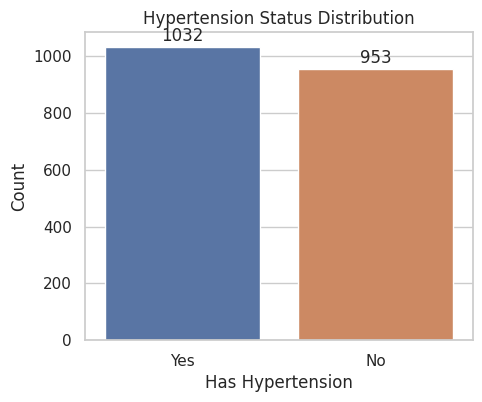

Has_Hypertension
Yes    51.989924
No     48.010076
Name: proportion, dtype: float64

In [6]:
# Distribution of the target variable
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=df, x="Has_Hypertension")
plt.title("Hypertension Status Distribution")
plt.xlabel("Has Hypertension")
plt.ylabel("Count")

# Add labels on bars
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 8),
        textcoords="offset points",
    )

plt.show()

df["Has_Hypertension"].value_counts(normalize=True) * 100


### Hypertension prevalence

The count plot shows that hypertension is relatively common in this sample. Using the value counts, approximately **52%** of individuals are labelled as hypertensive (`Yes`) and **48%** as non-hypertensive (`No`), indicating a nearly **balanced** classification problem.

Because the classes are well balanced, overall accuracy will be more informative than in heavily imbalanced settings, but it is still important to track **recall and precision for the hypertensive class**, given the higher clinical cost of missing true hypertensive cases.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

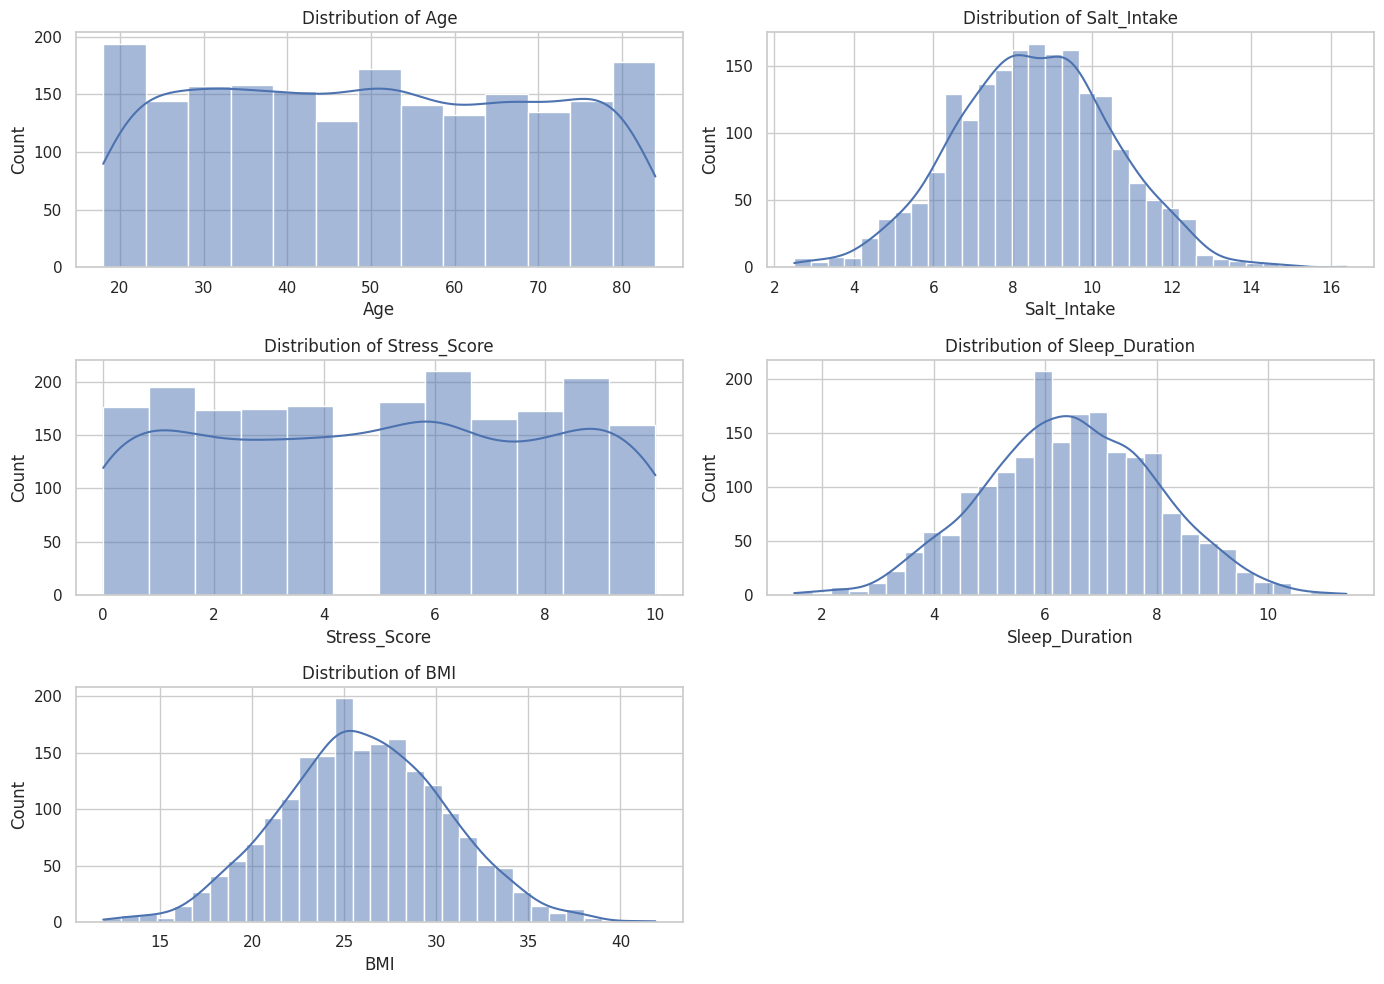

In [7]:
#Distributions of numerical features
num_cols = ["Age", "Salt_Intake", "Stress_Score", "Sleep_Duration", "BMI"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


From the histograms:

- **Salt_Intake**, **Sleep_Duration**, and **BMI** appear approximately bell-shaped, suggesting they are close to normally distributed in this sample.
- **Age** is more uniformly spread across the adult range rather than concentrated in a narrow band, which is useful for learning age-related patterns.
- **Stress_Score** looks more irregular and less smooth, which may reflect a coarse scoring scale or self-reported categories rather than a truly continuous variable.

Overall, the numerical features do not show extreme skewness, which simplifies modelling, but the different shapes hint that linear models and tree-based models may capture different aspects of the data.


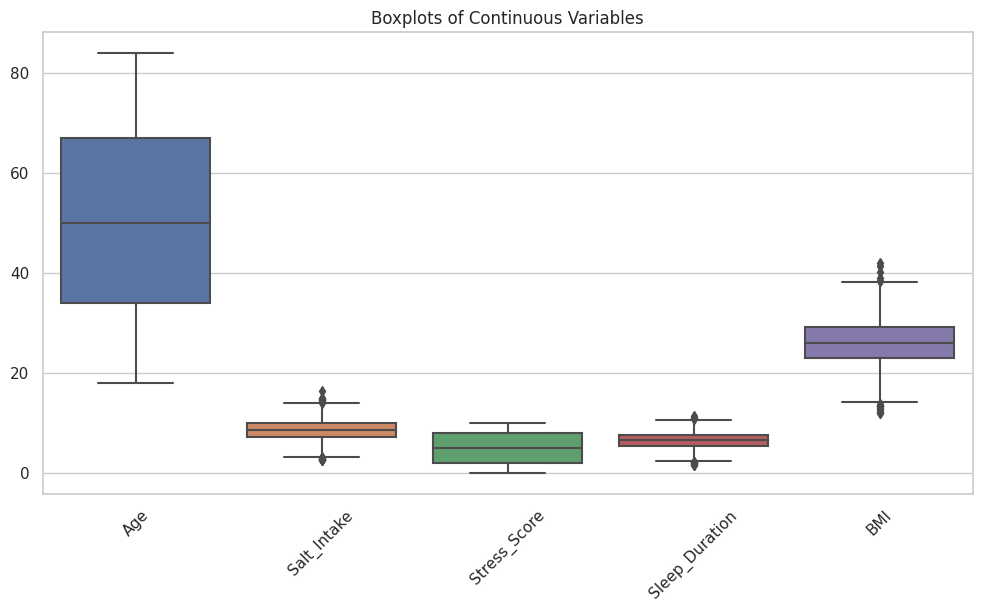

In [8]:
# Boxplot to inspect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["Age", "Salt_Intake", "Stress_Score", "Sleep_Duration", "BMI"]])
plt.title("Boxplots of Continuous Variables")
plt.xticks(rotation=45)
plt.show()


### Outliers and spread

The combined boxplots highlight how the continuous variables vary in scale and variability:

- **Age** spans a wide range, from late teens to mid‑80s, with a relatively broad interquartile range and several high‑age outliers. This suggests the dataset includes both young and older adults.
- **BMI** also shows substantial spread, with many observations above the upper whisker, indicating a non‑trivial number of individuals in overweight or obese ranges.
- **Salt_Intake**, **Stress_Score**, and **Sleep_Duration** have tighter interquartile ranges but still display a few extreme values, which may correspond to very high salt consumption, high stress, or unusually short or long sleep.

These patterns suggest that while most observations fall in typical ranges, there are meaningful extremes that models—especially tree‑based ones—can leverage to distinguish higher‑risk individuals.


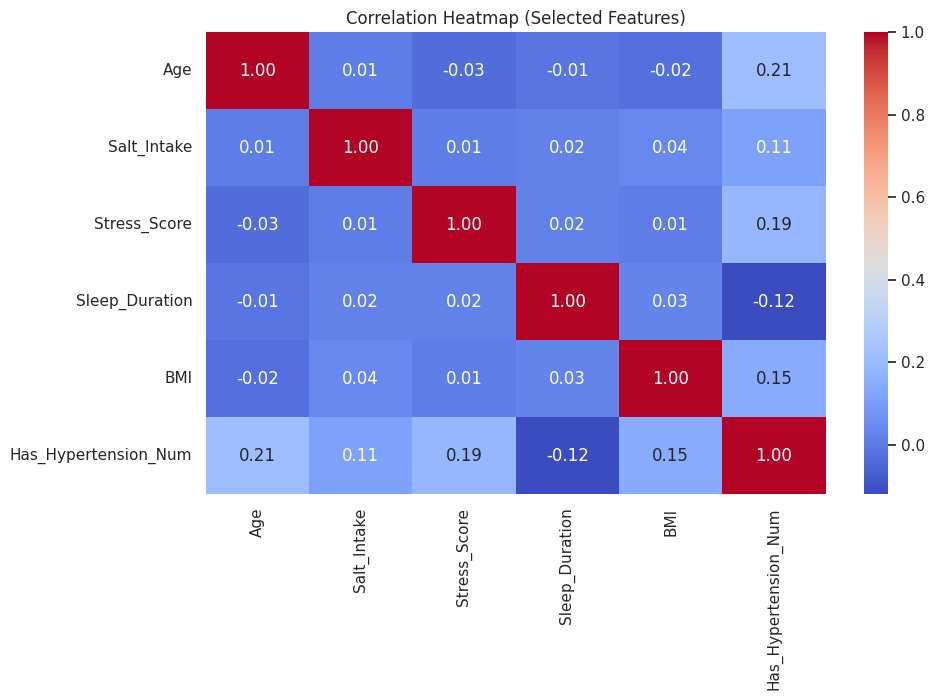

In [9]:
# Convert target to numeric temporarily for correlation (e.g., Yes/No -> 1/0)
df_corr = df.copy()
df_corr["Has_Hypertension_Num"] = df_corr["Has_Hypertension"].astype("category").cat.codes

plt.figure(figsize=(10, 6))
sns.heatmap(
    df_corr[["Age", "Salt_Intake", "Stress_Score", "Sleep_Duration", "BMI", "Has_Hypertension_Num"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Selected Features)")
plt.show()


### Correlations with hypertension

The correlation heatmap shows that all features have relatively modest linear correlations with `Has_Hypertension_Num`, with the strongest positive associations coming from **Age** (≈0.21), **Stress_Score** (≈0.19), and **BMI** (≈0.15). Salt intake also has a small positive correlation with hypertension, while **Sleep_Duration** is weakly negatively correlated, suggesting that shorter sleep tends to be linked with higher hypertension risk.

Although these correlations are not very high, they are consistent with domain expectations and indicate that hypertension risk is influenced by a combination of factors rather than a single dominant variable. This supports the choice of using both a simple linear model (Logistic Regression) and a non‑linear model (Random Forest) that can capture interactions between these features.


## 4. Data Preparation & Feature Engineering

The raw dataset mixes numeric and categorical variables and contains some missing values in the `Medication` column. To make the data suitable for machine learning models, this section:

- Handles missing values in a simple, transparent way.
- Encodes categorical variables (including the target) into numeric form.
- Splits the data into training and test sets.
- Scales numerical features for models that are sensitive to feature magnitude.


In [10]:
# Check missing values again for reference
df.isnull().sum()


Age                   0
Salt_Intake           0
Stress_Score          0
BP_History            0
Sleep_Duration        0
BMI                   0
Medication          799
Family_History        0
Exercise_Level        0
Smoking_Status        0
Has_Hypertension      0
dtype: int64

In [11]:
# Simple handling strategy:
# - Medication: treat missing as a separate "Unknown" category
df["Medication"] = df["Medication"].fillna("Unknown")


### Handling missing values

The only column with missing values is `Medication`. Instead of dropping these rows, we assign them to an **"Unknown"** category. This preserves all 1,985 observations while allowing the model to learn whether simply being on medication (or having unknown status) carries signal for hypertension risk.


In [12]:
# Encode target: Has_Hypertension (Yes/No -> 1/0)
df["Has_Hypertension"] = df["Has_Hypertension"].map({"Yes": 1, "No": 0})

# Categorical feature columns
cat_cols = ["BP_History", "Medication", "Family_History", "Exercise_Level", "Smoking_Status"]

# Use category codes for tree-based models; later we will note that
# one-hot encoding could be an alternative for linear models.
for col in cat_cols:
    df[col] = df[col].astype("category").cat.codes

df.head()


,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Medication,Family_History,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,1,6.4,25.8,4,1,1,0,1
1,32,11.7,10,1,5.4,23.4,4,0,1,0,0
2,78,9.5,3,1,7.1,18.7,4,0,2,0,0
3,38,10.0,10,0,4.2,22.1,0,0,1,0,1
4,41,9.8,1,2,5.8,16.2,3,0,2,0,0


### Encoding categorical variables

The target variable `Has_Hypertension` is converted from `"Yes"/"No"` labels to a binary numeric variable (1 = hypertensive, 0 = non‑hypertensive).

For the categorical predictors (`BP_History`, `Medication`, `Family_History`, `Exercise_Level`, `Smoking_Status`), we use integer category codes. This representation works well for **tree‑based models** like Random Forest, which split on values rather than assuming an order. In a more advanced version, we could compare this approach with **one‑hot encoding**, especially for linear models such as Logistic Regression.


### Feature matrix and target vector

After encoding, the feature matrix **X** contains all predictors (numeric and encoded categorical variables), while **y** holds the binary hypertension label. This separation makes it easier to apply scikit‑learn workflows for splitting, scaling, and modelling.


In [13]:
# Separate features and target
X = df.drop("Has_Hypertension", axis=1)
y = df["Has_Hypertension"]

X.shape, y.shape


((1985, 10), (1985,))

### Train–test split

The dataset is split into **80% training** and **20% test** data using a fixed random seed for reproducibility and **stratification** on the target variable. Stratification ensures that the proportion of hypertensive and non‑hypertensive individuals is similar in both the training and test sets, which leads to more reliable evaluation.


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((1588, 10), (397, 10))

### Feature scaling

Many machine learning algorithms, including Logistic Regression, work better when numerical features are on a similar scale. We therefore standardize the numeric variables (`Age`, `Salt_Intake`, `Stress_Score`, `Sleep_Duration`, `BMI`) to have mean 0 and unit variance, while leaving the encoded categorical features unchanged.

For **tree‑based models** such as Random Forest, scaling is not strictly required, but using the same scaled feature matrices (`X_train_scaled`, `X_test_scaled`) keeps the workflow consistent across models.


In [15]:
from sklearn.preprocessing import StandardScaler

num_features = ["Age", "Salt_Intake", "Stress_Score", "Sleep_Duration", "BMI"]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])


## 5. Modeling Approach & Evaluation

With the data cleaned, encoded, and split into training and test sets, we now build predictive models for hypertension risk.

Two complementary models are used:

- **Logistic Regression** as a simple and interpretable baseline.
- **Random Forest** as a non‑linear, tree‑based model that can capture complex interactions.

For each model, we evaluate performance on the held‑out test set using accuracy, precision, recall, F1‑score, and the confusion matrix, with particular attention to recall for hypertensive individuals.


In [16]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and fit Logistic Regression on scaled features
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_model.predict(X_test_scaled)

# Evaluation
log_accuracy = accuracy_score(y_test, y_pred_log)
log_cm = confusion_matrix(y_test, y_pred_log)
log_report = classification_report(y_test, y_pred_log, target_names=["No Hypertension", "Hypertension"])

print(f"Logistic Regression Accuracy: {log_accuracy:.3f}")
print("\nClassification Report:\n", log_report)
print("\nConfusion Matrix:\n", log_cm)


Logistic Regression Accuracy: 0.819

Classification Report:
                  precision    recall  f1-score   support

No Hypertension       0.80      0.83      0.81       191
   Hypertension       0.83      0.81      0.82       206

       accuracy                           0.82       397
      macro avg       0.82      0.82      0.82       397
   weighted avg       0.82      0.82      0.82       397


Confusion Matrix:
 [[158  33]
 [ 39 167]]


### Logistic Regression results

Logistic Regression achieves an overall accuracy of **0.819** on the test set. For the **No Hypertension** class, the model obtains a precision of **0.80** and recall of **0.83**, while for the **Hypertension** class it achieves a precision of **0.83** and recall of **0.81**.

The confusion matrix shows **158 true negatives**, **167 true positives**, **33 false positives**, and **39 false negatives**. In other words, the model correctly identifies most hypertensive individuals but still misses 39 of 206 cases, which is a limitation from a screening perspective where false negatives carry a higher clinical cost.


In [17]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Fit on the same scaled training data
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, target_names=["No Hypertension", "Hypertension"])

print(f"Random Forest Accuracy: {rf_accuracy:.3f}")
print("\nClassification Report:\n", rf_report)
print("\nConfusion Matrix:\n", rf_cm)


Random Forest Accuracy: 0.960

Classification Report:
                  precision    recall  f1-score   support

No Hypertension       0.97      0.94      0.96       191
   Hypertension       0.95      0.98      0.96       206

       accuracy                           0.96       397
      macro avg       0.96      0.96      0.96       397
   weighted avg       0.96      0.96      0.96       397


Confusion Matrix:
 [[180  11]
 [  5 201]]


### Random Forest results

The Random Forest model achieves an overall accuracy of **0.960** on the test set. For the **No Hypertension** class, it reaches a precision of **0.97** and recall of **0.94**, while for the **Hypertension** class it achieves a precision of **0.95** and a very strong recall of **0.98**, both with F1‑scores around **0.96**.

The confusion matrix shows **180 true negatives**, **201 true positives**, **11 false positives**, and only **5 false negatives**. Compared to Logistic Regression, the Random Forest misses far fewer hypertensive individuals, which is highly desirable in a screening context where failing to flag at‑risk patients is the most costly error.


### Model comparison

| Model               | Accuracy | Hypertension Precision | Hypertension Recall | Hypertension F1 |
|---------------------|----------|------------------------|---------------------|-----------------|
| Logistic Regression | 0.819    | 0.83                   | 0.81                | 0.82            |
| Random Forest       | 0.960    | 0.95                   | 0.98                | 0.96            |

Random Forest clearly outperforms Logistic Regression across all key metrics, especially in **recall for the hypertensive class** (0.98 vs 0.81). This makes Random Forest a more suitable primary model for hypertension risk prediction in this dataset, while Logistic Regression remains a useful, interpretable baseline.


## 6. Model Interpretation & Domain Insights

While high accuracy is encouraging, understanding **why** the Random Forest model makes its predictions is equally important. In this section, we examine feature importance to identify which risk factors drive hypertension prediction and connect our findings to clinical and lifestyle knowledge.


In [18]:
# Extract feature importance
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("Feature Importance (Top 10):")
print(feature_importance.head(10))


Feature Importance (Top 10):
BP_History        0.294794
Age               0.123824
Stress_Score      0.101896
BMI               0.100140
Salt_Intake       0.095735
Sleep_Duration    0.095358
Family_History    0.080689
Smoking_Status    0.076027
Medication        0.019021
Exercise_Level    0.012517
dtype: float64


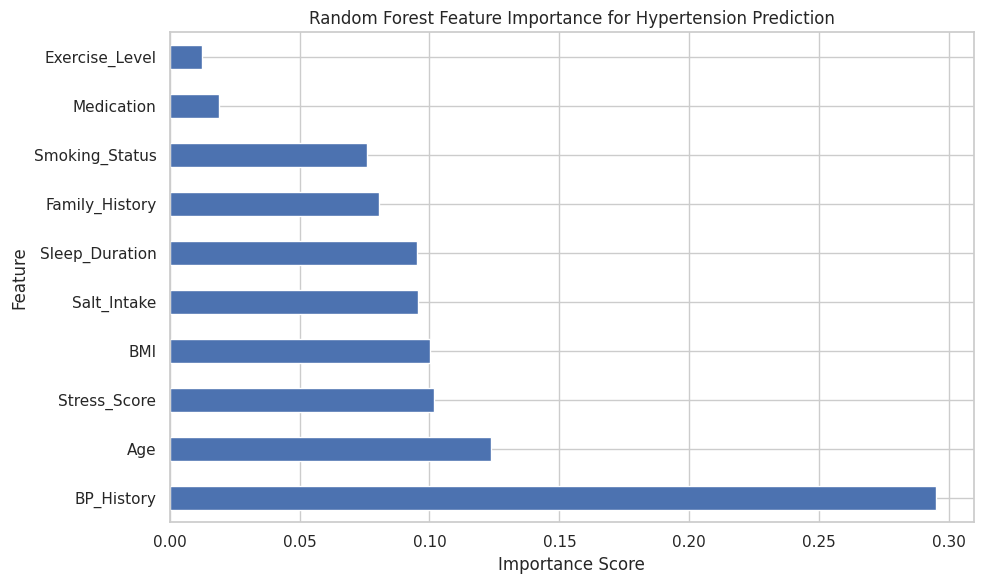

In [19]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind="barh")
plt.title("Random Forest Feature Importance for Hypertension Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Feature importance hierarchy

The Random Forest model ranks features based on how much they contribute to reducing prediction uncertainty (impurity) across the ensemble of trees. Features that appear early in decision trees and are used frequently get higher importance scores.

The chart above shows this ranking: which demographic, lifestyle, and clinical factors are most influential in the model's hypertension predictions.


### Top risk factors for hypertension

Based on the feature importance ranking, the strongest predictors of hypertension in this model are:

1. **BP_History** (29.5%)  
   Prior blood pressure status is by far the strongest predictor, accounting for nearly 30% of the model’s importance. This confirms that past clinical history is a critical flag.

2. **Age** (12.4%)  
   Age is the second most influential factor, reinforcing the known biological link between aging and vascular health.

3. **Stress_Score** (10.2%), **BMI** (10.0%), **Salt_Intake** (9.6%), and **Sleep_Duration** (9.5%)  
   These four lifestyle and physiological factors contribute almost equally (around 10% each). This cluster of modifiable risks highlights that stress management, weight control, diet, and sleep hygiene are all viable targets for prevention.

Other factors such as **Family_History** (8.1%) and **Smoking_Status** (7.6%) provide moderate signal, while **Medication** and **Exercise_Level** contribute less in this specific model.


### Clinical and public health implications

The feature importance analysis yields several actionable insights for hypertension prevention and screening:

**Screening and early detection**  
Blood pressure history emerges as the dominant predictor (29.5%), underscoring the critical importance of regular BP monitoring. Individuals with a known history of elevated BP or prior hypertension diagnosis should be prioritized for closer follow-up and intensive lifestyle counselling. In a university or occupational health setting, simple screening questionnaires focused on prior BP status can efficiently identify highest-risk individuals.

**Modifiable lifestyle factors**  
While age and family history are non-modifiable, the model highlights that **BMI, stress, sleep duration, and salt intake** collectively account for roughly 40% of the model's predictive power. This is highly encouraging from a prevention standpoint: interventions targeting these factors can meaningfully reduce hypertension risk. Specific opportunities include:

- **Weight management**: Weight loss programs, nutrition counselling, and regular physical activity.
- **Stress reduction**: Mindfulness training, counselling, yoga, or occupational stress management in high-pressure environments.
- **Sleep hygiene**: Education on consistent sleep schedules, limiting screen time, and addressing sleep disorders.
- **Dietary sodium**: Public awareness campaigns on hidden salt in processed foods and promotion of low-sodium alternatives.

**Age and university-age populations**  
Age contributes 12.4% to the model's predictions. While university students are generally younger, those with elevated stress, poor sleep (common during exams or heavy coursework), high BMI, or high salt intake can still develop hypertension. Early intervention in this population—when habits are being formed—may be especially effective at preventing long-term disease.

**Holistic, multifactorial approach**  
No single factor dominates except BP history. Hypertension risk emerges from the accumulation of multiple lifestyle and demographic factors. Effective prevention requires addressing multiple dimensions simultaneously, rather than focusing narrowly on any one factor.


### Model choice and trade-offs: Logistic Regression vs. Random Forest

Our analysis used two complementary models, each with distinct advantages and trade-offs:

**Logistic Regression**  
This linear model produces interpretable coefficients that directly show the direction and magnitude of each feature's effect on the log-odds of hypertension. For example, a positive coefficient on Age means increasing age raises hypertension risk, and the size of the coefficient quantifies this effect. This transparency makes Logistic Regression ideal for:

- Explaining predictions to non-technical stakeholders (clinicians, patients, policy makers).
- Regulatory or audit scenarios where model decisions must be fully justified.
- Initial hypothesis testing to confirm whether risk factors have the expected direction.

However, Logistic Regression assumes linear relationships and may miss complex interactions (e.g., how stress and poor sleep jointly amplify risk).

**Random Forest**  
This ensemble of decision trees can capture non-linear relationships and interaction effects, leading to higher predictive accuracy (0.960 vs. 0.819). Feature importance in Random Forest reflects how frequently and how early a feature is used in splitting decisions, but it does not directly encode direction or magnitude of effects. Random Forest is preferable when:

- Accuracy and recall (especially for the minority/high-risk class) are paramount.
- Complex, non-linear patterns and interactions matter.
- The focus is prediction rather than explanation.

The downside is reduced interpretability: a high feature importance score does not immediately tell you whether the relationship is positive or negative.

**Recommended hybrid approach**  
In production, both models can coexist: use Random Forest as the primary predictor (leveraging its higher accuracy), while consulting Logistic Regression coefficients to understand the direction of effects for the top predictors. This combines the best of both: strong prediction performance with interpretable insights.


## 7. Limitations & Future Work

No modelling project is perfect. This section summarizes key limitations of the current work and outlines concrete next steps to improve reliability and real-world usefulness.

### 7.1 Limitations

**Single train–test split**  
Model performance is evaluated on a single 80/20 train–test split. Although the results are strong—especially for the Random Forest—this setup does not fully capture variability due to different splits of the data. More robust evaluation would use cross-validation and, ideally, an external validation dataset.

**Dataset scope and realism**  
The dataset represents a specific sample with a particular combination of demographics and lifestyle factors. It may not fully capture the diversity of real-world populations (e.g., different countries, age distributions, comorbidities, or measurement methods). As a result, the model’s high accuracy might not generalize unchanged to other settings.

**Simple handling of categorical variables**  
Categorical features were encoded using integer category codes. While this works well for tree-based models, it can implicitly introduce arbitrary ordering for linear models. A more thorough approach would compare one-hot encoding, target encoding, or other schemes, especially when interpretability of coefficients is important.

**Limited treatment of missing data and potential confounders**  
Missing values in `Medication` were handled via a single "Unknown" category, which is simple but may not fully represent underlying patterns in medication use. Additionally, the analysis does not explicitly control for potential confounders or interactions (for example, how age, BMI, and family history jointly influence risk).

**Interpretability of non-linear model**  
Random Forest provides feature importance scores but not detailed local explanations for individual predictions. For sensitive applications, stakeholders might require more granular interpretability (e.g., why a specific patient was flagged as high risk).

### 7.2 Future work

**More robust evaluation**  
- Apply **k-fold cross-validation** to estimate performance variability and reduce dependence on a single train–test split.  
- If additional data become available, evaluate the model on an **external validation cohort** to test generalizability.

**Improved feature engineering and encoding**  
- Experiment with **one-hot encoding** and **target encoding** for categorical variables, and compare their impact on both Logistic Regression and Random Forest performance.  
- Explore additional engineered features, such as combined stress–sleep indicators or BMI categories, to capture non-linear patterns more explicitly.

**Richer modelling and calibration**  
- Try alternative models such as **Gradient Boosting Machines** (e.g., XGBoost, LightGBM) and compare them with the current Random Forest.  
- Assess **probability calibration** (e.g., with Platt scaling or isotonic regression) so that predicted probabilities better reflect true risk levels.

**Deeper interpretability**  
- Use methods like **SHAP values** or **partial dependence plots** to explain how each feature influences predictions at both global and individual levels.  
- Combine these tools with the Logistic Regression coefficients to build clinician-friendly summaries of risk drivers.

**Deployment-oriented extensions**  
- Wrap the final model in a simple **API or web dashboard** where users can enter age, BMI, stress, sleep, and lifestyle information to obtain a personalized risk estimate.  
- Integrate clear **disclaimers** that the tool is for educational or preliminary screening purposes and does not replace professional medical advice.



## 8. Credits & Reproducibility

This notebook was developed as part of a personal learning and portfolio project on hypertension risk prediction. The analysis builds on the **Hypertension Dataset** hosted on **Kaggle**, which provided the demographic, lifestyle, and clinical features used throughout this work. Anyone interested in extending or modifying the analysis can access the original data via the corresponding Kaggle dataset page.

Guidance on structuring the workflow, strengthening the modelling approach, and improving the storytelling aspects of this notebook was supported by an AI assistant (Perplexity), which helped refine the narrative, code organization, and interpretation of results.

To **replicate this notebook**, you can follow these steps:

1. Open the Kaggle dataset and create a new Kaggle Notebook using the same dataset as an input source.  
2. Copy the code and markdown cells from this notebook, or adapt them to your own style and experiments.  
3. Run all cells from top to bottom to reproduce the data loading, EDA, preprocessing, model training, and evaluation steps.  
4. Modify hyperparameters, try alternative models, or add new visualizations to explore how the results change.

If you build on this work, consider linking back to the original dataset on Kaggle and documenting your own changes and insights so others can learn from your version as well.
